In [1]:
import torch
import os
os.environ['NEURITE_BACKEND'] = 'pytorch'
os.environ['VXM_BACKEND'] = 'pytorch'
import voxelmorph as vxm
import matplotlib.pyplot as plt
import glob
import re
import csv
from tifffile import imwrite
import numpy as np
from PIL import Image
import fnmatch
from collections import defaultdict
import shutil

from my_utils_v2 import Utils_v2

In [ ]:
def register_multiple_tissues_with_overlap(moving, fixed, model, device,stain1=None,stain2=None,stain3=None):
    """
    Register two images and corresponding stains with overlap
    Args:
    moving: moving image
    fixed: fixed image
    stain1: First stain image
    stain2: Second stain image
    stain3: Third stain image
    model: Model
    device: Device
    stain: Stain image
    Returns: Registered tissue and stain image
    """
    block_size = (1024, 1024)
    overlap = 200
    stride = (block_size[0] - overlap, block_size[1] - overlap)
    height, width = moving.shape

    # Accumulator arrays for averaging overlapping areas
    full_tissue = np.zeros_like(moving, dtype=np.float32)
    stain1 = np.zeros_like(moving, dtype=np.float32) if stain1 is not None else None
    stain2 = np.zeros_like(moving, dtype=np.float32) if stain2 is not None else None
    stain3 = np.zeros_like(moving, dtype=np.float32) if stain3 is not None else None
    count_map = np.zeros_like(moving, dtype=np.float32)

    num_blocks_x = (width - overlap) // stride[1] + 1
    num_blocks_y = (height - overlap) // stride[0] + 1

    for i in range(num_blocks_y):
        for j in range(num_blocks_x):
            y_start = i * stride[0]
            x_start = j * stride[1]
            y_end = min(y_start + block_size[0], height)
            x_end = min(x_start + block_size[1], width)

            moving_block = moving[y_start:y_end, x_start:x_end]
            fixed_block = fixed[y_start:y_end, x_start:x_end]
            stain1_block = stain1[y_start:y_end, x_start:x_end] if stain1 is not None else None
            stain2_block = stain2[y_start:y_end, x_start:x_end] if stain2 is not None else None
            stain3_block = stain3[y_start:y_end, x_start:x_end] if stain3 is not None else None

            moving_block = moving_block[np.newaxis, ..., np.newaxis]
            fixed_block = fixed_block[np.newaxis, ..., np.newaxis]
            if stain1_block is not None:
                stain1_block = stain1_block[np.newaxis, ..., np.newaxis]
            if stain2_block is not None:
                stain2_block = stain2_block[np.newaxis, ..., np.newaxis]
            if stain3_block is not None:
                stain3_block = stain3_block[np.newaxis, ..., np.newaxis]
            if moving_block.shape!=(1, 1024, 1024, 1):
                continue
            moving_block = torch.from_numpy(moving_block).to(device).float().permute(0, 3, 1, 2)
            fixed_block = torch.from_numpy(fixed_block).to(device).float().permute(0, 3, 1, 2)

            fwd_pred,fwd_pred_field = model(moving_block, fixed_block, registration=True)
            if stain1_block is not None:
                stain1_block = torch.from_numpy(stain1_block).to(device).float().permute(0, 3, 1, 2)
                stain1_block = model.transformer(stain1_block, fwd_pred_field)
                stain1[y_start:y_end, x_start:x_end] += stain1_block.detach().cpu().numpy().squeeze()
            if stain2_block is not None:
                stain2_block = torch.from_numpy(stain2_block).to(device).float().permute(0, 3, 1, 2)
                stain2_block = model.transformer(stain2_block, fwd_pred_field)
                stain2[y_start:y_end, x_start:x_end] += stain2_block.detach().cpu().numpy().squeeze()
            if stain3_block is not None:
                stain3_block = torch.from_numpy(stain3_block).to(device).float().permute(0, 3, 1, 2)
                stain3_block = model.transformer(stain3_block, fwd_pred_field)
                stain3[y_start:y_end, x_start:x_end] += stain3_block.detach().cpu().numpy().squeeze()
            # Update full image and field accumulators
            full_tissue[y_start:y_end, x_start:x_end] += fwd_pred.detach().cpu().numpy().squeeze()
            count_map[y_start:y_end, x_start:x_end] += 1

    # Averaging the accumulated values
    full_tissue /= count_map
    if stain3 is not None:
        stain1 /= count_map
        stain2 /= count_map
        stain3 /= count_map
        return full_tissue,stain1,stain2,stain3
    elif stain2 is not None:
        stain1 /= count_map
        stain2 /= count_map
        return full_tissue,stain1,stain2
    elif stain1 is not None:
        stain1 /= count_map
        return full_tissue,stain1
    else:
        return full_tissue

In [7]:
fixed='/fs5/p_masi/baos1/rudravg/MXIF/MXIF/Helmsley/MxIF/Set06/GCA113ACA/Registered/GCA113ACA_DAPI_DAPI_30ms_ROUND_00.tif'
moving='/fs5/p_masi/baos1/rudravg/MXIF/MXIF/Helmsley/MxIF/Set06/GCA113ACA/Registered/GCA113ACA_DAPI_DAPI_12ms_ROUND_19.tif'
stain1='/fs5/p_masi/baos1/rudravg/MXIF/MXIF/Helmsley/MxIF/Set06/GCA113ACA/Registered/GCA113ACA_ACTG1_CY5_1000ms_ROUND_19.tif'
mask='/fs5/p_masi/baos1/rudravg/MXIF/MXIF/Helmsley/MxIF/Set06/GCA113ACA/Registered/GCA113ACA_RetentionMask.tif'
moving,_,_=Utils_v2.load_tissues_for_overlap(moving,mask)
fixed,_,_=Utils_v2.load_tissues_for_overlap(fixed,mask)
stain1,_,_=Utils_v2.load_tissues_for_overlap(stain1,mask)

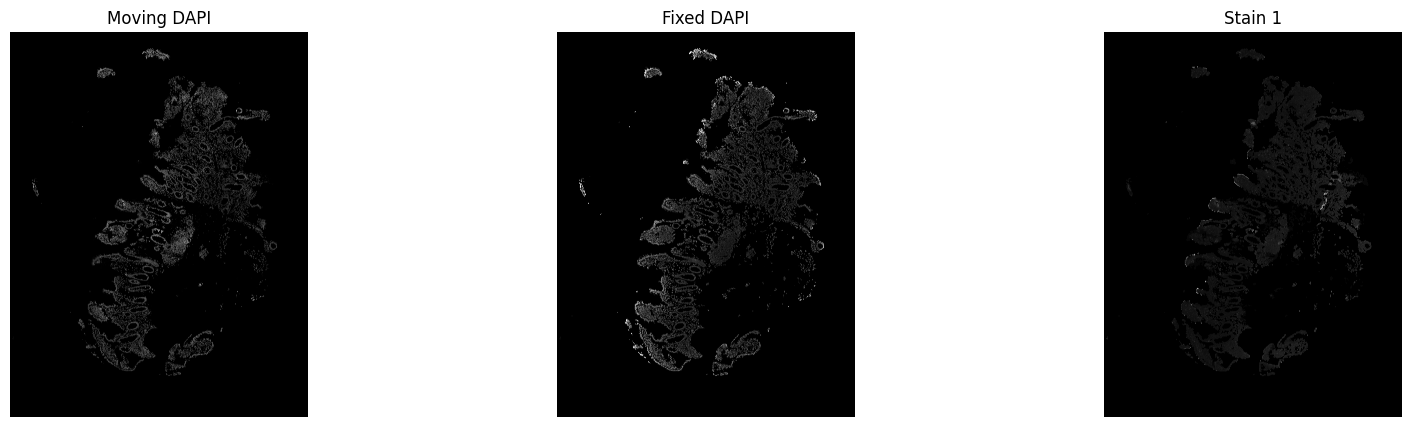

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

axs[0].imshow(moving, cmap='gray')
axs[0].set_title('Moving DAPI')

axs[1].imshow(fixed, cmap='gray')
axs[1].set_title('Fixed DAPI')

axs[2].imshow(stain1, cmap='gray')
axs[2].set_title('Stain 1')

for ax in axs:
    ax.axis('off')

plt.show()

In [9]:
model_path='/home-local/rudravg/test_DAPI/1024_Dataset_V2/trial2_epochs/epoch_113/epoch_113.pth'
model,device=Utils_v2.load_model(model_path) #Write this code

/home/local/VANDERBILT/rudravg/miniconda3/envs/dapi_reg/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [11]:
block_size = (1024, 1024)
overlap = 200
stride = (block_size[0] - overlap, block_size[1] - overlap)
height, width = moving.shape
full_tissue = np.zeros_like(moving, dtype=np.float32)
stain1_accumulator = np.zeros_like(moving, dtype=np.float32)
count_map = np.zeros_like(moving, dtype=np.float32)

# Calculate the number of blocks in x and y directions
num_blocks_x = (width - overlap) // stride[1] + 1
num_blocks_y = (height - overlap) // stride[0] + 1

# Process each block
for i in range(num_blocks_y):
    for j in range(num_blocks_x):
        y_start = i * stride[0]
        x_start = j * stride[1]
        y_end = min(y_start + block_size[0], height)
        x_end = min(x_start + block_size[1], width)

        moving_block = moving[y_start:y_end, x_start:x_end]
        fixed_block = fixed[y_start:y_end, x_start:x_end]
        stain1_block = stain1[y_start:y_end, x_start:x_end]

        moving_block = moving_block[np.newaxis, ..., np.newaxis]
        fixed_block = fixed_block[np.newaxis, ..., np.newaxis]
        stain1_block = stain1_block[np.newaxis, ..., np.newaxis]

        if moving_block.shape != (1, 1024, 1024, 1):
            continue

        moving_block = torch.from_numpy(moving_block).to(device).float().permute(0, 3, 1, 2)
        fixed_block = torch.from_numpy(fixed_block).to(device).float().permute(0, 3, 1, 2)

        fwd_pred, fwd_pred_field = model(moving_block, fixed_block, registration=True)
        stain1_block = torch.from_numpy(stain1_block).to(device).float().permute(0, 3, 1, 2)
        stain1_block = model.transformer(stain1_block, fwd_pred_field)

        # Update full image and field accumulators
        full_tissue[y_start:y_end, x_start:x_end] += fwd_pred.detach().cpu().numpy().squeeze()
        stain1_accumulator[y_start:y_end, x_start:x_end] += stain1_block.detach().cpu().numpy().squeeze()
        count_map[y_start:y_end, x_start:x_end] += 1

# Averaging the accumulated values
full_tissue /= count_map
stain1_accumulator /= count_map

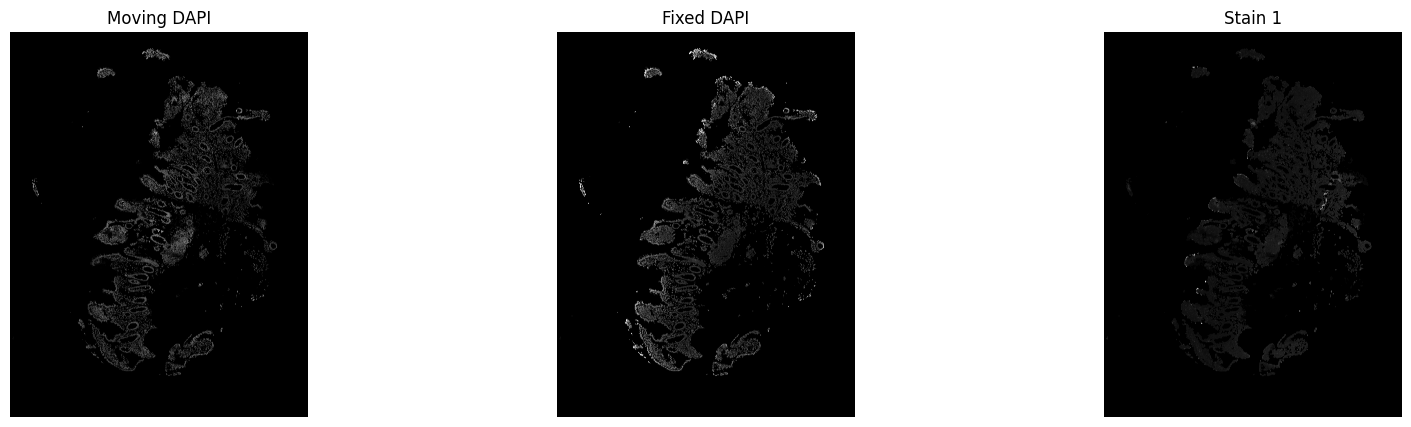

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

axs[0].imshow(full_tissue, cmap='gray')
axs[0].set_title('Moving DAPI')

axs[1].imshow(fixed, cmap='gray')
axs[1].set_title('Fixed DAPI')

axs[2].imshow(stain1_accumulator, cmap='gray')
axs[2].set_title('Stain 1')

for ax in axs:
    ax.axis('off')

plt.show()

In [16]:
Utils_v2.calculate_ncc(stain1.ravel(),stain1.ravel())

array([0.62459004], dtype=float32)

In [18]:
Utils_v2.calculate_ncc(stain1_accumulator.ravel(),stain1.ravel())

array([0.9682965], dtype=float32)

In [19]:
Utils_v2.calculate_ncc(moving.ravel(),fixed.ravel())

array([0.8197838], dtype=float32)

In [20]:
Utils_v2.calculate_ncc(fixed.ravel(),full_tissue.ravel())

array([0.8723774], dtype=float32)